This tutorials reproduces section III.C from:

- L. Tsunaki, A. Singh, S. Trofimov, & B. Naydenov. (2025). Digital Twin Simulations Toolbox of the Nitrogen-Vacancy Center in Diamond. arXiv:2507.18759 quant-ph. [2507.18759](https://arxiv.org/abs/2507.18759).

While Tutorial 3 focuses on basic operations with the NV component and Tutorial 4 and 5 discuss three applications related to sensing and computing, this tutorial introduces a problem relevant to quantum communication and cryptography.
The process of quantum teleportation consists of transferring the state of one qubit to another spatially separated one, through non-local properties of quantum entanglement.
This way, making itself a corner stone of quantum networks.
Here, we simulate an adapted version of an unconditional teleportation between two NV centers, as originally demonstrated by:

- W. Pfaff, B. J. Hensen, H. Bernien, S. B. van Dam, M. S. Blok, T. H. Taminiau, M. J. Tiggelman, R. N. Schouten, M. Markham, D. J. Twitchen, and R. Hanson, Unconditional quantum teleportation between distant solid-state quantum bits, Science 345, 532 (2014).

Specifically, we focus on simulating a simplified version of the MW and RF pulses implementation, rather than the photonic component of the experiment, which is on itself the greatest technical challenge of the experiment and the main source of errors.

In [1]:
from quaccatoo import NV, compose_sys, PulsedSim, Analysis, plot_histogram
from qutip import tensor, basis, qeye, fock_dm, ptrace
import numpy as np
import copy

# 1. System Definition

This simple form of teleportation consists of two network parties: 'Alice' and 'Bob'.
Alice has a 14NV center with two qubits, the nitrogen nuclear spin and the electron spin.
Bob has another distant NV, where the nuclear spin can be neglected.
This system can be defined in QuaCCAToo using:

In [2]:
NVa = NV(B0=25, units_B0='mT', N=14)
NVb = NV(B0=18, units_B0='mT', N=0)

NVa.truncate(mS=1, mI=1)
NVb.truncate(mS=1)

sys = compose_sys(NVb, NVa)

where we assume some typical values for $B_0$.
To avoid performance issues of simulating a large Hilbert space with dimension $d=3^2=27$ from the three spins-1 subsystems, the `truncate` method is used to exclude the $\ket{m_S=+1}$ and $\ket{m_I=+1}$ levels.
Which, as seen in the previous tutorials, does not compromise the modeling of the system, as long as the transition frequencies are well separated compared to the spectral width of the excitation. 
This way, the system is defined within the subspaces $m_{S,I}=0,-1$, with a total dimension of $d=2^3=8$ instead.
Lastly, the `compose_sys` function is used to compose the two NV centers from Alice and Bob, which internally calculates the new attributes of the `sys` object.

Initially, the two NVs' electron spins are in a maximally entangled Bell state $\ket{\Psi^-} = (\ket{01} - \ket{10})/\sqrt{2}$, where $\ket{0} \equiv \ket{m_S=0}$ and $\ket{1} \equiv \ket{m_S=-1}$.
While this is presented as a postulate for the simulation applications, the experimental generation of the Bell state poses a great technological challenge, given the poor spectral stability of NVs and high relative background counts.
This is achieved through a photon emission mixing by a beam splitter and mutual photon detection, which thus heralds an entanglement event for the two NVs' electron spins.
The optical properties of the NVs optical emission can be nonetheless improved by micro-engineering of the diamond surface.

Apart from the initial state of the electron, the state $\ket{\psi} = \alpha \ket{0} + \beta \ket{1}$ to be teleported between Alice and Bob is initially stored in Alice's 14N spin.
Experimentally, it can initialized into the state $\ket{1} \equiv \ket{m_I = -1}$ by a projective measurement of the electron spin. 
Which is then rotated to the state $\ket{\psi}$ with the appropriate resonance pulses, as discussed in Tutorial 3.
In the software component, the initial state of the three spins $\ket{\Psi^-}\otimes\ket{\psi}$ is hence represented by:

In [3]:
Psi_ = tensor(basis(2, 0),basis(2,1)) - tensor(basis(2,1),basis(2,0))

alpha = 1
beta = 0

psi = alpha*basis(2,0)+beta*basis(2,1)

sys.rho0 = tensor(Psi_,psi).unit()

for given values of $\alpha, \beta \in  \mathbb{C}$.
By taking $\alpha=\beta=1/\sqrt{2}$ we have the initial state $\ket{+X}$, with $\alpha=1/\sqrt{2}$ and $\beta=i/\sqrt{2}$ we have $\ket{+Y}$, and finally with $\alpha=1$ and $\beta=0$ we have $\ket{+Z}$.
Here, we first consider the $\ket{+Z}$ state.

To define the remaining experimental constants of the experiment we use:

In [4]:
# Rabi frequencies of the spins in MHz
w1_rf = .2
w1_mwa = 16
w1_mwb = 22
w1_cnot = 2.14/3**.5

# pi pulse times
tpi_rf = 1/(2*w1_rf)
tpi_mwa = 1/(2*w1_mwa)
tpi_mwb = 1/(2*w1_mwb)
tpi_cnot = 1/(2*w1_cnot)

# Larmor frequencies of the spins
w0_rf = NVa.RF_freqs[2]
w0_mwa = NVa.MW_freqs[0]
w0_cnot = NVa.energy_levels[2]
w0_mwb = NVb.MW_freqs[0]

# Hamiltonian terms for the RF and MW pulses
h1_rf = w1_rf * tensor(qeye(2), NVa.RF_h1)
h1_mwa = w1_mwa * tensor(qeye(2), NVa.MW_h1)
h1_cnot = w1_cnot * tensor(qeye(2), NVa.MW_h1)
h1_mwb = w1_mwb * tensor(NVb.MW_h1, qeye(2), qeye(2))

sol_opt = {'nsteps':1e9}

# 2. Hadamard Gate Optimization

Before realizing the protocol, the phase $\varphi^{rf}$ of the nuclear pulse during the Hadamard gate needs to be optimized to reduce phase accumulations between states. This is achieved with:

np.float64(2.95)

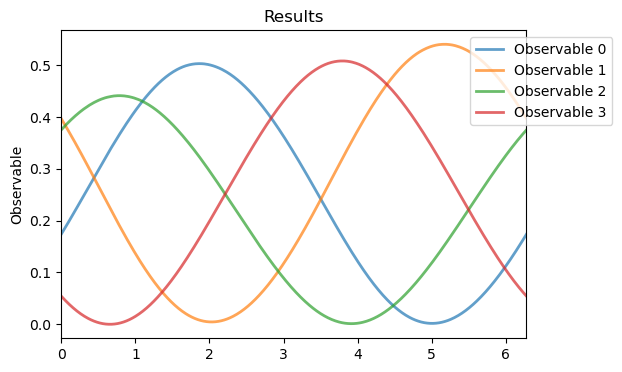

In [5]:
sys2 = copy.deepcopy(NVa)

sys2.rho0 = tensor(
    basis(2, 0) - basis(2, 1), basis(2, 0) - basis(2, 1)
).unit()

sys2.observable = [
    tensor(fock_dm(2, 0), fock_dm(2, 0)),
    tensor(fock_dm(2, 0), fock_dm(2, 1)),
    tensor(fock_dm(2, 1), fock_dm(2, 0)),
    tensor(fock_dm(2, 1), fock_dm(2, 1))
]

def hadamard_phi(phi_rf, **kwargs):
    """
    CNOT and Hadamard gates sequence for teleportation.
    The phase of the RF pulse is optimized to maximize the fidelity of the teleportation.

    Parameters
    ----------
    phi_rf : float
        Phase of the RF pulse in radians.
    kwargs : dict
        Dictionary containing the pulse parameters:
        - tpi_rf: float
            Duration of the RF pi pulse.
        - tpi_mwa: float
            Duration of the MW pi pulse for the first NV.
        - tpi_cnot: float
            Duration of the CNOT gate.
        - w0_rf: float
            Larmor frequency of the RF pulse.
        - w0_mwa: float
            Larmor frequency of the first NV's MW pulse.
        - w0_cnot: float
            Larmor frequency of the CNOT gate.
        - h1_rf: Qobj
            Hamiltonian term for the RF pulse.
        - h1_mwa: Qobj
            Hamiltonian term for the first NV's MW pulse.
        - h1_cnot: Qobj
            Hamiltonian term for the CNOT gate.
    """
    seq_in = PulsedSim(sys2)

    seq_in.add_pulse(kwargs['tpi_cnot'], kwargs['h1_cnot'], pulse_params={'f_pulse': kwargs['w0_cnot'], 'phi_t':np.pi/2}, options=sol_opt)

    seq_in.add_pulse(kwargs['tpi_rf']/2, kwargs['h1_rf'], pulse_params={'f_pulse': kwargs['w0_rf'], 'phi_t':phi_rf}, options=sol_opt)
    seq_in.add_pulse(kwargs['tpi_mwa'], kwargs['h1_mwa'], pulse_params={'f_pulse': kwargs['w0_mwa'], 'phi_t':np.pi/2}, options=sol_opt)
    seq_in.add_pulse(kwargs['tpi_rf']/2, kwargs['h1_rf'], pulse_params={'f_pulse': kwargs['w0_rf'], 'phi_t':phi_rf}, options=sol_opt)

    return seq_in.rho

phi_array = np.arange(0, 2*np.pi, 0.01)

seq_phi = PulsedSim(sys2)
seq_args = {
    'tpi_rf': tpi_rf,
    'tpi_mwa': tpi_mwa,
    'tpi_cnot': tpi_cnot,
    'w0_rf': w0_rf,
    'w0_mwa': w0_mwa,
    'w0_cnot': w0_cnot,
    'h1_rf': w1_rf * NVa.RF_h1,
    'h1_mwa': w1_mwa * NVa.MW_h1,
    'h1_cnot': w1_cnot * NVa.MW_h1,
}

seq_phi.run(phi_array, hadamard_phi, sequence_kwargs=seq_args)

Analysis(seq_phi).plot_results()
phi_rf = phi_array[np.argmax(seq_phi.results[0]**2 + seq_phi.results[3]**2)]
phi_rf

By taking the maximum value for observables 0 and 3, as done in the Ref., we obtain $\varphi^{rf}=2.95$.
Finally, we also have the freedom to choose $\tau_2$ and the total refocus time `tau_refocus` such that the final fidelities are optimized. From previous tests, we observe that:

In [6]:
tau_refocus = 2.26

leads to high fidelities and gives a solution $\tau_2>0$. The user can test this by changing the value.

# 3. Teleportation Protocol

Given the initial state and the optmized values of `tau_refocus` and $\varphi^{rf}$, the teleportation protocol can then be simulated.
Since there is no standard predefined sequence in QuaCCAToo for this protocol, we can simulate it by instantiating an object from `PulsedSim` with `sys` as an argument:

In [7]:
seq = PulsedSim(sys)

The first part of the teleportation protocol is a CNOT gate to Alice's electron spin conditioned to her nuclear spin.
This is expressed by a soft selective $\hat{R}_y(\pi)$ pulse of the $\ket{m_S=0} \leftrightarrow \ket{m_S=-1}$ electron transition for the $\ket{m_I=-1}$ nuclear state.
The intensity of this pulse needs to be small, in order to ensure a narrow bandwidth excitation.
Furthermore, the $\ket{m_I=0}$ states would ideally remain unchanged during the operation.
But due to the system's evolution under the time-independent Hamiltonian $\hat{H}_0$ during the finite pulse length, these states also accumulate a phase.
This phase is minimized however by taking the Rabi frequency of the CNOT pulse as $\omega_1^{cnot} = a_\parallel^n/\sqrt{3}$, where $a_\parallel^n$ is the parallel component of the hyperfine interaction on the NV center.

A pulse with the parameters as defined above can be added to the sequences with the `add_pulse` method using:

In [8]:
# CNOT gate
seq.add_pulse(
	duration = tpi_cnot,
	h1 = h1_cnot,
	pulse_params = {'f_pulse':w0_cnot,
		'phi_t':np.pi/2},
	options = sol_opt
	)

By default, `add_pulse` assumes a square pulse and 100 time steps in the time array discretization, which should not be confused with the `nsteps` key for the solver options dictionary that is increased to `1e9`.
In the lab frame, the $\phi$ angle of the rotation axis is expressed in terms of the temporal phase of the excitation field `phi_t`.
Within this implementation, the simulation is already executed upon calling `add_pulse`, differently from predefined methods which require the `run` command.
However, if the user desires to execute a sequence in parallel in regards to some changing variable, it can be defined within a function and called with `run` as done with Hadamard optmization.

One of the main challenges of the pulse implementation of the protocol is the loss of the relative phase between the qubits due to the dynamics from $\hat{H}_0$.
Specifically, all three spins precess with different Larmor frequencies $\omega_0$ during the finite pulse lengths.
Which makes it necessary to correct for this phase accumulation in Bob's qubit while Alice performs the teleportation operation on her qubits.
For that, we implement a refocusing scheme similar to a Hahn echo, with a free evolution of $\tau_1$ followed by a $\hat{R}_y(\pi)$ pulse and another free evolution of $\tau_2$.
The free evolution times $\tau_1$ and $\tau_2$ are chosen such that the $\hat{R}_y(\pi)$ is exactly in the middle of the whole protocol duration prior to the state reconstruction, and thus Bob's qubit ends the protocol with the same state as he initially had.
This way, we have the first free evolution time given by 
$$
	\tau_1 + t_\pi^{cnot} + \frac{t_\pi^B}{2} = \frac{T}{2} ,
$$
where $T$ is the total duration of the protocol.

To implement the refocus scheme we calculate the free evolution times from the optmized value of `tau_refocus` and use the `add_free_evolution` and `add_pulse` methods:

In [9]:
# Refocus scheme
T = tpi_cnot + tau_refocus + tpi_rf/2 + tpi_mwa + tpi_rf/2
tau1 = T/2 - tpi_cnot - tpi_mwb/2
tau2 = tau_refocus - tau1 - tpi_mwb

seq.add_free_evolution(tau1)
seq.add_pulse(
	duration = tpi_mwb,
	h1 = h1_mwb,
	pulse_params = {'f_pulse': w0_mwb,
		'phi_t':np.pi/2},
	options = sol_opt
	)
seq.add_free_evolution(tau2)

In the Ref., the phase of Bob's qubit is protected with an XY4 sequence.
However, in this simulation, the implementation would become more complex than the straight experimental realization with multi-channel pulse generation, due to the intricate time placement of the $\pi$-pulses on Bob's qubit.
In the end, this difference in the refocusing scheme will require small adjustments to Bob's state reconstruction pulses, as discussed in the following analysis.

The next step of the protocol is Hadamard gate to Alice's nuclear spin, which can be decomposed with two rotations, such as $\hat{R}_{y}(\pi/2)\hat{R}_{z}(\pi)$.
In this case nonetheless, the first rotation on the $z$-axis responsible for correcting the phase can be omitted, hence configuring a pseudo-Hadamard gate.
In addition, due to the fact that the transition frequency of the nuclear spin depends on the $m_S$ state, the gate can be composed by three pulses: a conditional rotation of $\hat{R}_{\varphi^{rf}}(\pi/2)$ on the nuclear spin over some chosen axis $\varphi^{rf}$, an unconditional rotation of $\hat{R}_y(\pi)$ on Alice's electron, and another rotation of $\hat{R}_{\varphi^{rf}}(\pi/2)$ on the nuclei.
This way, the first pulse changes the nuclear state for $m_S=-1$, then the electron spin is inverted and the same RF pulses is applied again.
Assuming some typical values for the pulse parameters, where the Rabi frequency of Alice's electron for a hard pulse `w1_mwa` is now much larger than for the CNOT gate, the three pulses are simulated using:

In [10]:
# Hadamard gate
seq.add_pulse(
	duration = tpi_rf/2,
	h1 = h1_rf,
	pulse_params={'f_pulse':w0_rf,
		'phi_t':phi_rf},
	options=sol_opt
	)
seq.add_pulse(
	duration = tpi_mwa,
	h1 = h1_mwa,
	pulse_params={'f_pulse': w0_mwa,
		'phi_t':np.pi/2},
	options=sol_opt
	)
seq.add_pulse(
	duration = tpi_rf/2,
	h1 = h1_rf,
	pulse_params={'f_pulse':w0_rf,
		'phi_t':phi_rf},
	options=sol_opt
	)

with the pulse phase `phi_rf` as optimized above.

At this point, the teleportation of the $\ket{\psi} = \alpha \ket{0} + \beta \ket{1}$ state to Bob's NV has already taken place, who has a superposition state composed of four different possible combinations with the coefficients $\alpha$ and $\beta$.
Thus, with Alice measuring her qubits, Bob's qubit will be projected in one of the four combinations.
Physically, the electron spin is measured by the fluorescence observable, while the nuclear spin is measured using the electron spin as an auxiliary qubit, which gives rise to an observable as
$$
	\hat{F}_{I^n} = \hat{1} \otimes \hat{1} \otimes \ket{1}\bra{1} .
$$
Given the two observables, Alice's measurements are implemented with the `measure_qsys` method:

In [11]:
# Alice measurements
obs0 = tensor(qeye(2),fock_dm(2, 0),qeye(2))
c0 = 1 - seq.measure_qsys(observable=obs0)

obs1 = tensor(qeye(2),qeye(2),fock_dm(2, 1))
c1 = seq.measure_qsys(observable=obs1)

Besides collapsing the system in one of the eigenstates of the observables, the two measurements performed with the `measure_qsys` method yield two classical bits $c_0$ and $c_1$.
These two classical bits are then communicated to Bob via a classical channel, who now needs to reconstruct the $\ket{\psi}$ state on his qubit with some operation $\hat{U}(c_0, c_1)$, which also depends on the input state $\ket{\psi}$ in this application.

## 3.1 Z Input

First, we take the $\ket{+Z}$ input state.
If Alice's electron qubit is measured in the $\ket{1}$ state yielding $c_0, \, c_1 = 1, \, 0$ or $c_0, \, c_1 = 1, \, 1$, Bob does not need to perform any operation on his qubit, which is already in the state $\ket{\psi}$.
However, if Alice measures her electron in the state $\ket{0}$ with $c_0, \, c_1 = 0, \, 1$ or $c_0, \, c_1 = 0, \, 0$, then Bob needs to perform a rotation of $\hat{R}_y(\pi)$ so that his qubit is then in the state $\ket{\psi}$.
Altogether then, the state reconstruction for an initial state $\ket{+Z}$ is implemented with:

In [12]:
if c0 == 0. and c1 == 0.:
	seq.add_pulse(tpi_mwb, h1_mwb, pulse_params={'f_pulse':w0_mwb, 'phi_t':np.pi/2}, options=sol_opt)
elif c0 == 0. and c1 == 1.:
	seq.add_pulse(tpi_mwb, h1_mwb, pulse_params={'f_pulse':w0_mwb, 'phi_t':np.pi/2}, options=sol_opt)
elif c0 == 1. and c1 == 0.:
	pass
elif c0 == 1. and c1 == 1.:
	pass

To compare the real part of the densitry matrix of the teleported state with the ideal state, we use the `plot_histogram` function:

Fidelity: 0.9981076874465541


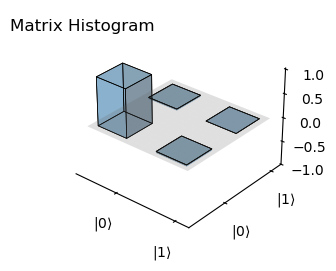

In [13]:
rho_sim = ptrace(seq.rho*seq.rho.dag(), 0)
rho_theo = psi * psi.dag()
plot_histogram(rho_sim, rho_theo, component='real')

Now the imaginary:

Fidelity: 0.9981076874465541


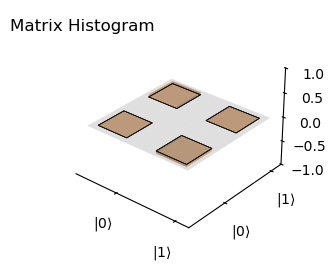

In [14]:
plot_histogram(rho_sim, rho_theo, component='imag')

## 3.2 X Input

In the $\ket{+X}$ and $\ket{+Y}$ inputs, $\pi/2$ pulses are also required to reconstruct the teleported state.
Where in these cases, the phase accumulated by Bob's qubit alters the final state and needs to be corrected, which is not the case for the $\pi$-pulse with a complete population inversion.
This can be achieved by adding a free evolution of duration $\tau_3$ such that the qubit will have completed an integer number of Larmor precessions and thus will have returned to the same state.
Mathematically, this means that the free evolution duration to cancel the phase accumulation must be
$$
	\tau_3 = \frac{\lceil \omega_0^B t_\pi^B/2 \rceil}{\omega_0^B} - \frac{t_\pi^B}{2} ,
$$
where $\omega_0^B$ is the Larmor frequency for Bob's NV and $t_\pi^B$ the $\pi$-pulse duration, as previously defined.
In addition, $\lceil \cdot \rceil$ denotes the ceiling function, which rounds the value up to the nearest integer. Finally, the $\pi$ rotations around the $z$-axis $\hat{R}_z(\pi)$ present in some $\hat{U}(c_0, c_1)$ can also be obtained simply with a free evolution of duration $1/(2\omega_0^B)$.

For $\ket{+X}$ state we then have:

c0 = 1.0, c1 = 0.0
Fidelity: 0.9889566216661088


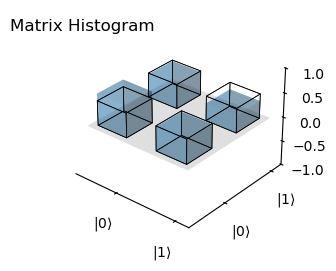

In [ ]:
# Initial state
alpha = 1/2**.5
beta = 1/2**.5

psi = alpha*basis(2,0)+beta*basis(2,1)
sys.rho0 = tensor(Psi_,psi).unit()

seq = PulsedSim(sys)

# CNOT gate
seq.add_pulse(
	duration = tpi_cnot,
	h1 = h1_cnot,
	pulse_params = {'f_pulse':w0_cnot,
		'phi_t':np.pi/2},
	options = sol_opt
	)

# Refocus scheme
seq.add_free_evolution(tau1)
seq.add_pulse(
	duration = tpi_mwb,
	h1 = h1_mwb,
	pulse_params = {'f_pulse': w0_mwb,
		'phi_t':np.pi/2},
	options = sol_opt
	)
seq.add_free_evolution(tau2)

# Hadamard gate
seq.add_pulse(
	duration = tpi_rf/2,
	h1 = h1_rf,
	pulse_params={'f_pulse':w0_rf,
		'phi_t':phi_rf},
	options=sol_opt
	)
seq.add_pulse(
	duration = tpi_mwa,
	h1 = h1_mwa,
	pulse_params={'f_pulse': w0_mwa,
		'phi_t':np.pi/2},
	options=sol_opt
	)
seq.add_pulse(
	duration = tpi_rf/2,
	h1 = h1_rf,
	pulse_params={'f_pulse':w0_rf,
		'phi_t':phi_rf},
	options=sol_opt
	)

# Alice measurements
obs0 = tensor(qeye(2),fock_dm(2, 0),qeye(2))
c0 = 1 - seq.measure_qsys(observable=obs0)

obs1 = tensor(qeye(2),qeye(2),fock_dm(2, 1))
c1 = seq.measure_qsys(observable=obs1)

print(f'c0 = {c0}, c1 = {c1}')

tau3 = np.ceil(w0_mwb*tpi_mwb/2)/w0_mwb  - tpi_mwb/2

# Bob recounstruction of teleported state
if c0 == 0. and c1 == 0.:
    # R-y(pi/2)
    seq.add_pulse(tpi_mwb/2, h1_mwb, pulse_params={'f_pulse': w0_mwb, 'phi_t': -np.pi/2}, options=sol_opt)
    seq.add_free_evolution(tau3)
elif c0 == 0. and c1 == 1.:
    # Ry(pi/2)
    seq.add_pulse(tpi_mwb/2, h1_mwb, pulse_params={'f_pulse': w0_mwb, 'phi_t': np.pi/2}, options=sol_opt)
    tau3 += 1/(2*w0_mwb)
    seq.add_free_evolution(tau3)    
elif c0 == 1. and c1 == 0.:
    # Ry(pi/2)
    seq.add_pulse(tpi_mwb/2, h1_mwb, pulse_params={'f_pulse': w0_mwb, 'phi_t': np.pi/2}, options=sol_opt)
    tau3 += 1/(2*w0_mwb)
    seq.add_free_evolution(tau3)
elif c0 == 1. and c1 == 1.:
    # R-y(pi/2)
    seq.add_pulse(tpi_mwb/2, h1_mwb, pulse_params={'f_pulse': w0_mwb, 'phi_t': -np.pi/2}, options=sol_opt)
    seq.add_free_evolution(tau3)W

rho = ptrace(seq.rho*seq.rho.dag(), 0)
rho_theo = psi * psi.dag()
plot_histogram(rho, rho_theo,component='real')

Fidelity: 0.9889566216661088


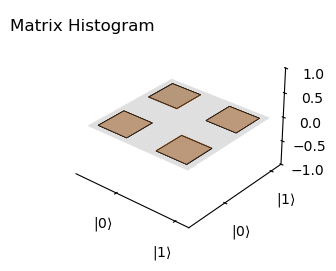

In [16]:
plot_histogram(rho, rho_theo, component='imag')

## 3.3 Y Input

Finnaly, for $\ket{+Y}$ state:

c0 = 1.0, c1 = 0.0
Fidelity: 0.9779163711979024


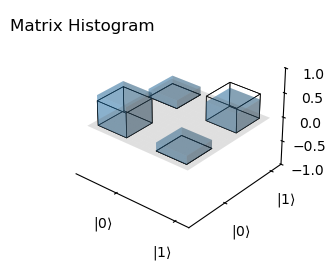

In [17]:
# Initial state
alpha = 1/2**.5
beta = 1j/2**.5

psi = alpha*basis(2,0)+beta*basis(2,1)
sys.rho0 = tensor(Psi_,psi).unit()

seq = PulsedSim(sys)

# CNOT gate
seq.add_pulse(
	duration = tpi_cnot,
	h1 = h1_cnot,
	pulse_params = {'f_pulse':w0_cnot,
		'phi_t':np.pi/2},
	options = sol_opt
	)

# Refocus scheme
seq.add_free_evolution(tau1)
seq.add_pulse(
	duration = tpi_mwb,
	h1 = h1_mwb,
	pulse_params = {'f_pulse': w0_mwb,
		'phi_t':np.pi/2},
	options = sol_opt
	)
seq.add_free_evolution(tau2)

# Hadamard gate
seq.add_pulse(
	duration = tpi_rf/2,
	h1 = h1_rf,
	pulse_params={'f_pulse':w0_rf,
		'phi_t':phi_rf},
	options=sol_opt
	)
seq.add_pulse(
	duration = tpi_mwa,
	h1 = h1_mwa,
	pulse_params={'f_pulse': w0_mwa,
		'phi_t':np.pi/2},
	options=sol_opt
	)
seq.add_pulse(
	duration = tpi_rf/2,
	h1 = h1_rf,
	pulse_params={'f_pulse':w0_rf,
		'phi_t':phi_rf},
	options=sol_opt
	)

# Alice measurements
obs0 = tensor(qeye(2),fock_dm(2, 0),qeye(2))
c0 = 1 - seq.measure_qsys(observable=obs0)

obs1 = tensor(qeye(2),qeye(2),fock_dm(2, 1))
c1 = seq.measure_qsys(observable=obs1)

print(f'c0 = {c0}, c1 = {c1}')

tau3 = np.ceil(w0_mwb*tpi_mwb/2)/w0_mwb  - tpi_mwb/2

# Bob recounstruction of teleported state
if c0 == 0. and c1 == 0.:
    # Rz(pi)Rx(pi/2)
    seq.add_pulse(tpi_mwb/2, h1_mwb, pulse_params={'f_pulse': w0_mwb, 'phi_t': 0}, options=sol_opt)
    tau3 += 1/(2*w0_mwb)
    seq.add_free_evolution(tau3)
elif c0 == 0. and c1 == 1.:
    # R-x(pi/2)
    seq.add_pulse(tpi_mwb/2, h1_mwb, pulse_params={'f_pulse': w0_mwb, 'phi_t': np.pi}, options=sol_opt)
    seq.add_free_evolution(tau3)    
elif c0 == 1. and c1 == 0.:
    # Rz(pi)Rx(pi/2)
    seq.add_pulse(tpi_mwb/2, h1_mwb, pulse_params={'f_pulse': w0_mwb, 'phi_t': 0}, options=sol_opt)
    tau3 += 1/(2*w0_mwb)
    seq.add_free_evolution(tau3)
elif c0 == 1. and c1 == 1.:
    # R-x(pi/2)
    seq.add_pulse(tpi_mwb/2, h1_mwb, pulse_params={'f_pulse': w0_mwb, 'phi_t': np.pi}, options=sol_opt)
    seq.add_free_evolution(tau3)

rho = ptrace(seq.rho*seq.rho.dag(), 0)
rho_theo = psi * psi.dag()
plot_histogram(rho, rho_theo,component='real')

Fidelity: 0.9779163711979024


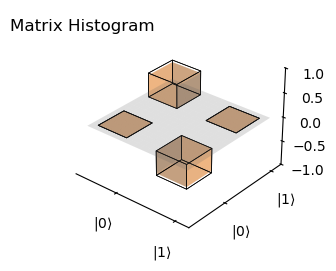

In [18]:
plot_histogram(rho, rho_theo, component='imag')

We observe a strong agreement overall between the simulated and predicted teleported states.
Nonetheless, small deviations can be seen in the diagonal elements of the $\ket{+X}$ and $\ket{+Y}$ states, which can be attribute to the phase accumulations.
The corresponding fidelities are larger than the experimental values provided.
This can be attributed to the fact that the simulation software does not consider errors in the optical initialization of the entangled state, or the readout, neither decoherence of the spins.
Nonetheless, this application complements the original work with a rigorous simulation of the MW and RF pulses component of the protocol.

The non-adoption of a rotating frame introduces a new layer of complexity to the dynamics of the system related to the phase accumulations of each qubit in the laboratory frame.
Where these phase accumulations are often overlooked in perturbative models, such as the RWA, which may lead to discrepancies in experimental results.
Another interesting result can be observed by comparing the fidelities for each input state.
The $\ket{+Z}$ state along the quantization axis of the NVs presents higher fidelities, due to the fact that this state is less prone to the phase accumulations in the perpendicular plane of the quantization.